En este cuaderno, se explica e implementa el proceso de calcular las distancias a los vehículos que se encuentran en el mismo carril que nuestro coche.

Empezamos importando las líbrerías y creando los directorios necesarios

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision.transforms import functional as F_torch

from train import get_model_instance_segmentation
from predictions import get_predictions, draw_predictions
from road_lines_sobel import road_line_filter_image, calculate_road_lines, get_road_mask, search_around_poly
from road_lines_canny import image_edges

VEHICLE_CONFIG = {
    1:  1.8,
    2:  2.6,
    3:  2.6,
    4:  2.4,
    5:  2.5,
    6:  0.8,
    7:  0.6
}
FOCAL_LENGTH = 2000

CWD = os.getcwd()
PATH_MODEL = os.path.join(CWD, "final_model/maskrcnn_cityscapes.pth")
PATH_IMAGES = os.path.join(CWD, "display_elements/distance_prediction/images")
PATH_VIDEOS = os.path.join(CWD, "display_elements/distance_prediction/videos")
PATH_RESULT_IMAGES = os.path.join(CWD, "results/distance_prediction/images")
PATH_RESULT_VIDEOS = os.path.join(CWD, "results/distance_prediction/videos")

try:
    os.mkdir(PATH_RESULT_IMAGES)
    os.mkdir(PATH_RESULT_VIDEOS)
except FileExistsError:
    pass

print(f"Images: {PATH_IMAGES}")
print(f"Videos: {PATH_VIDEOS}")
print(f"Resulting images: {PATH_RESULT_IMAGES}")
print(f"Resulting videos: {PATH_RESULT_VIDEOS}")

Images: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\display_elements/distance_prediction/images
Videos: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\display_elements/distance_prediction/videos
Resulting images: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/distance_prediction/images
Resulting videos: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/distance_prediction/videos


## Cargar el modelo

Primero, debemos cargar el modelo entrenado con el fine-tunning, para realizar las predicciones.

In [2]:
# Set the acceleration device (or the CPU if cuda is not available)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Get the model pre-trained model
num_classes = 8
model = get_model_instance_segmentation(8)

# Load the calculated weights in fine-tunning process
data_model = torch.load(PATH_MODEL, map_location=device, weights_only=False)
model.load_state_dict(data_model['model_state_dict'])

# Move the model to the acceleration device and set the model into evaluation mode
model.to(device)
model.eval() 

print("Loaded model and ready to inference.")

Loaded model and ready to inference.


## Obtener los vehículos en el mismo carril

Lo primero que se debe hacer es filtrar aquellos vehículos que no se encuentran en el carril de nuestro vehículo, para quedarse con los vehículos objetivo.

A continuación se implementa una función que comprueba si un vehículo se encuentra en el carril, comprobando si el centro inferior de la máscara del vehículo choca con la máscara del carril.

In [3]:
def is_in_lane(lane_mask, box):
    """ Verify wether the vehicle is over the lane """
    x1, y1, x2, y2 = box
    center_x = int((x1 + x2) / 2)
    center_y = int(y2) 

    if 0 <= center_x < lane_mask.shape[1] and 0 <= center_y < lane_mask.shape[0]:
        # True if the vechile point in the lane_mask is colored
        return lane_mask[center_y, center_x, 1] > 0 
    return False

## Representar distancia

Para poder representar graficamente la distancia, se implementa una función que devuelve un gradiente de color asociado a una distancia: cuanto más cerca más rojo, y cuanto más lejos más verde.

In [4]:
def get_distance_color(dist):
    """ Generate RGB color gradient: Red (near) -> Green (far) """
    if dist < 10: return (0, 0, 255) # Red
    if dist > 50: return (0, 255, 0) # Green
    
    # Gradient
    ratio = (dist - 10) / 40
    g = int(255 * ratio)
    r = int(255 * (1 - ratio))
    return (0, g, r)

## Dibujar resultados en imagen

A continuación, se define una función que, dada una imagen, dibuja sobre ella las máscaras de segmentación y las bounding boxes etiquetadas con la clase que el modelo a asignado a esa instancia. Y para los vehículos que se encuentran en el carril, calcula el gradiente de color en base a la distancia, y añade la distancia a la etiqueta.

In [5]:
def draw_predictions_in_lanes(image_tensor, pred_masks, pred_boxes, pred_labels, lane_mask, focal_lenght=FOCAL_LENGTH):
    """
        This method draw over a given image the segmentation masks and bounding boxes of given predictions, 
        and for those vehicles on the lane mask, calculate and represents their distance
    Args:
        image_tensor: the image in Tensor format
        pred_masks: The segmentation masks
        pred_boxes: The bounding boxes
        pred_labels: The labels for each predicted class
        lane_mask: The mask for the own lane


    Returns:
        processed_image: the image with masks and bounding boxes drawn on it
    """
    
    # if there are no elements detected, returns the original image
    if len(pred_boxes) == 0:
        return (image_tensor * 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy()

    # Lists with colors and labels for each detected vehicle
    dynamic_colors = []
    dynamic_labels = []
    
    # Asign especific color and distance for vehicles in same lane, and default for the others
    for i in range(len(pred_boxes)):
        box = pred_boxes[i].cpu().numpy().astype(int)
        label_id = pred_labels[i].item()
        
        # If the vehicle is in the same lane
        if is_in_lane(lane_mask, box):
            # Calculate distance
            pixel_w = max(1, box[2] - box[0])
            real_w = VEHICLE_CONFIG[label_id]
            dist = (real_w * focal_lenght) / pixel_w
            
            # Get the RGB color
            color = get_distance_color(dist) 
            label = f"Class: {label_id}\nDistance: {dist:.1f}m"
        else:
            # If it is in other lane
            color = (255, 255, 0)           # Cyan
            label = f"Class: {label_id}"

        dynamic_colors.append(color)
        dynamic_labels.append(label)

    # Draw the predictions over the image
    processed_image = draw_predictions(image_tensor, pred_masks, pred_boxes, dynamic_labels, 
                                       masks_colors=dynamic_colors, custom_labels=True)

    return processed_image

Por último se va a implementar una función que dada una imagen, realiza todo el proceso mencionado anteriormente, para devolver la imagen con las distancias calculadas y representadas con los vehículos segmentados.

In [6]:
def predict_distance(image, M, Minv, img_h, img_w, model, 
                     device='cpu', score_threshold=0.5, draw_lane=False):

    filter_image, _ = road_line_filter_image(image)
    no_persp = cv2.warpPerspective(filter_image, M, (img_w, img_h), flags=cv2.INTER_LINEAR)
    left_fit, right_fit, _ = calculate_road_lines(no_persp)

    # Create lane mask
    lane_mask = np.zeros_like(image)

    if left_fit is not None and right_fit is not None:
        # Get the road mask
        lane_mask = get_road_mask(no_persp, left_fit, right_fit, Minv, img_h, img_w)


    # ------------ VEHICLE SEGMENTATION MASKS ------

    # Convert the image to Tensor format
    image_tensor = F_torch.to_tensor(image).to(device)
    masks, boxes, labels = get_predictions(image_tensor, model, img_h, img_w, score_threshold)


    # ------------ GENERATE RESULTING FRAME --------

    # Draw the lane
    if draw_lane:
        image_processed = cv2.addWeighted(image, 1, lane_mask, 0.3, 0)
        image_tensor = F_torch.to_tensor(image_processed).to(device)

    image_processed = draw_predictions_in_lanes(image_tensor,
                                                masks, boxes, labels, lane_mask
                                                )
    
    return image_processed

Se va a mostrar a continuación un ejemplo de este proceso

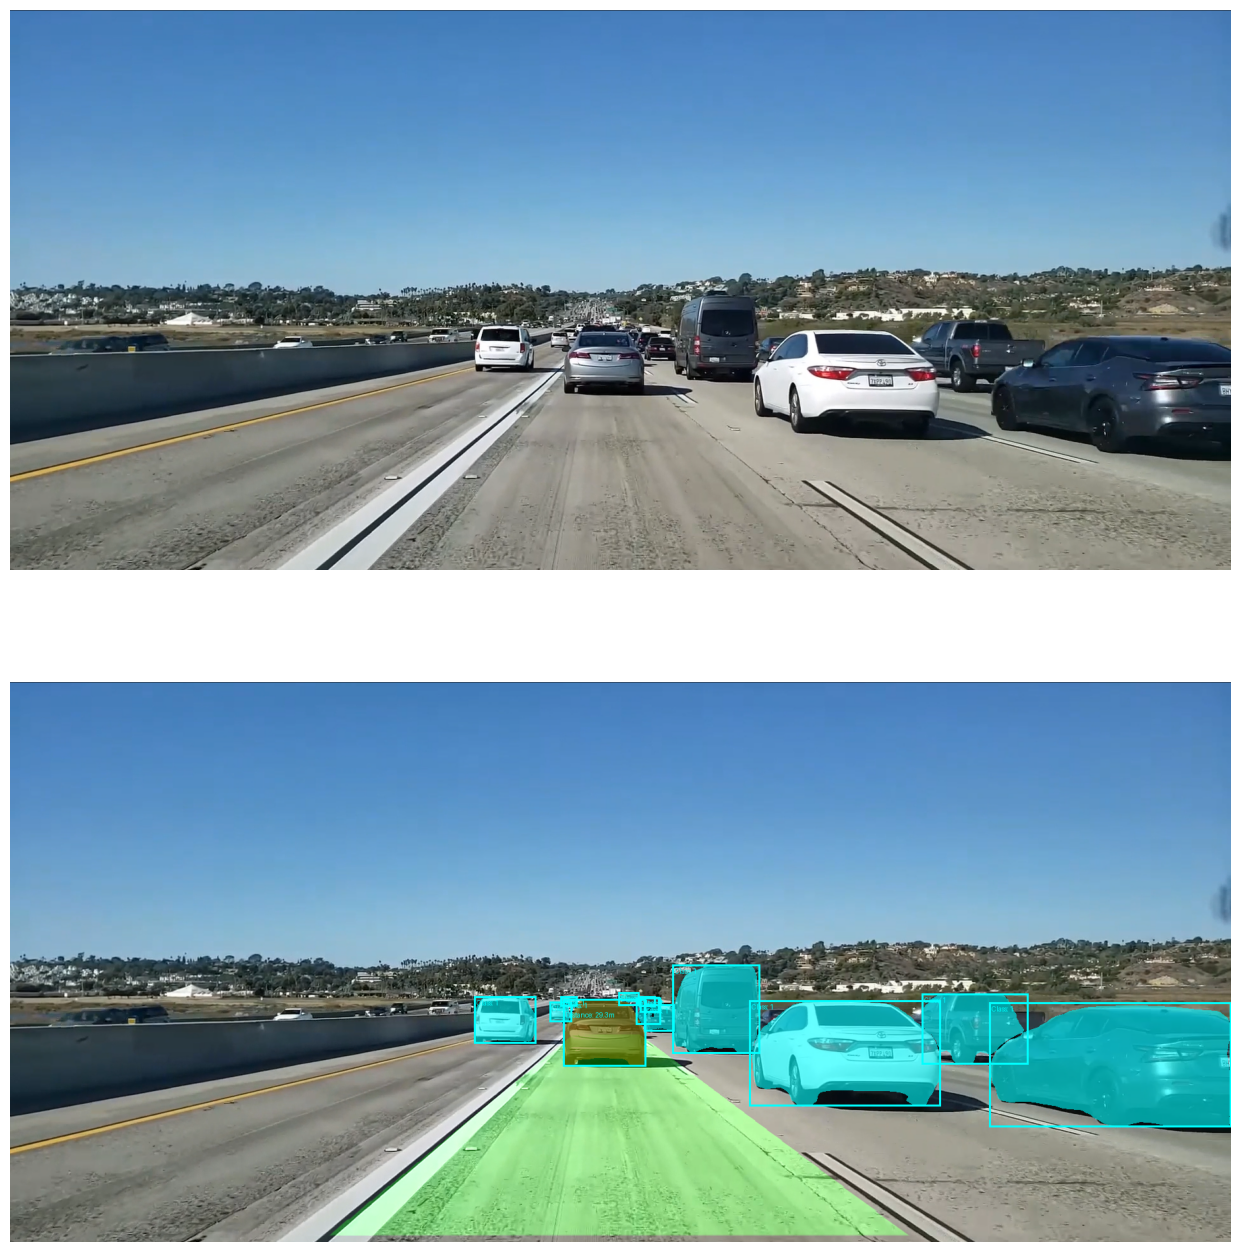

In [7]:
# Get the image
image_name = "road3.png"
img_path = os.path.join(PATH_IMAGES, image_name)

image = cv2.imread(img_path)

img_h, img_w = image.shape[:2]

p1_top_left = (int(img_w * 0.45), int(img_h * 0.63)) 
p2_top_right = (int(img_w * 0.52), int(img_h * 0.63)) 
p3_bot_right = (int(img_w * 0.84), int(img_h * 0.99)) 
p4_bot_left  = (int(img_w * 0.28), int(img_h * 0.99)) 

src_pts = np.float32([p1_top_left, p2_top_right, p3_bot_right, p4_bot_left])

dst_pts = np.float32([(int(img_w*0.4), 0), 
                                  (int(img_w*0.6), 0), 
                                  (int(img_w*0.6), img_h), 
                                  (int(img_w*0.4), img_h)
                    ])

M = cv2.getPerspectiveTransform(src_pts, dst_pts)
Minv = np.linalg.inv(M)

image_processed = predict_distance(image, M, Minv, img_h, img_w, model, device, draw_lane=True)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_processed = cv2.cvtColor(image_processed, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(24, 16))
plt.subplot(2,1,1)
plt.imshow(image)
plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(image_processed)
plt.axis('off')
plt.show()

## Predicción en vídeo

Se implementa a continuación una función que calcula las predicciones de distancia en una secuencia de vídeo

In [8]:
def process_distance_video(video_path, output_path, model, device='cpu', score_threshold=0.5, 
                           frames_per_prediction=1, src_pts=None, dst_pts=None, focal_lenght=FOCAL_LENGTH, draw_lane=False, mode='sobel'):
    """
        This function procces a video by predicting the distance of the vechiles in the same lane that the vehicle from which the secuence is recorded.

    Args:
        video_path: The path to the video file
        output_path: The path where the resulting video is written
        model: The segmentation model that predicts masks and bouding boxes
        device: The device where the computations will be done. CPU by default
        score_threshold: The asurance of the model for shwoing the instance predictions 
        frames_per_prediction: The amount of frames that passes beetwen each prediction. The smaller, the faster the process, but results will be worst. Default is 1 (every frame)
        src_pts: The points of a rectangle align with the road lines in the image from the perspective of the car.
        dst_pts: The points of the src_pts rectanggle, but from a "bird eye" perspective.
        focal_lenght: The focal lenght of the camera that recorded the video

    Returns:
        true if video is correctly processed, False if an error ocurred.
    """
    # Control frames per second
    if frames_per_prediction <= 0:
        print("Frames per predictions must be > 0\n")
        return False

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return False
    else:
        # Create Writer with same properties that the original video
        img_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        img_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS) 
        out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (img_w, img_h))
        
        print(f"Processing video... Resolution: {img_w}x{img_h}, FPS: {fps}")

        if src_pts is None:
            p1_top_left = (int(img_w * 0.45), int(img_h * 0.63)) 
            p2_top_right = (int(img_w * 0.52), int(img_h * 0.63)) 
            p3_bot_right = (int(img_w * 0.84), int(img_h * 0.99)) 
            p4_bot_left  = (int(img_w * 0.28), int(img_h * 0.99)) 

            src_pts = np.float32([p1_top_left, p2_top_right, p3_bot_right, p4_bot_left])

        if dst_pts is None:
            dst_pts = np.float32([(int(img_w*0.4), 0), 
                                  (int(img_w*0.6), 0), 
                                  (int(img_w*0.6), img_h), 
                                  (int(img_w*0.4), img_h)
                    ])
            
        # Calculate homography
        M = cv2.getPerspectiveTransform(src_pts, dst_pts)
        Minv = np.linalg.inv(M)
        
        frame_count = 0
        prev_max_height = 0     # First process the whole image
        RESET_MAX_HEIGHT = 25   # Each 25 frames, model predicts the whole image

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break # Video ended

            # ------------ LANE MASK ------------------------

            if mode=='sobel':
                filter_frame, _ = road_line_filter_image(frame)
            elif mode== 'canny':
                filter_frame = image_edges(frame, lower_threshold=5, upper_threshold=250)
                
            no_perspective = cv2.warpPerspective(filter_frame, M, (img_w, img_h), flags=cv2.INTER_LINEAR)
            left_fit, right_fit, _ = calculate_road_lines(no_perspective)

            # Create lane mask
            lane_mask = np.zeros_like(frame)

            if left_fit is not None and right_fit is not None:
                # Get the road mask
                lane_mask = get_road_mask(no_perspective, left_fit, right_fit, Minv, img_h, img_w)


            # ------------ VEHICLE SEGMENTATION MASKS ------

            # Convert the image to Tensor format
            frame_tensor = F_torch.to_tensor(frame).to(device)
            
            # Let between model predictions as many frames as the parameter frames_per_prediction
            if frame_count % frames_per_prediction == 0:

                # Each certain amount of frames, processes the whole image
                if frame_count % RESET_MAX_HEIGHT == 0:
                    prev_max_height = 0

                # Process the frame and write it in the ouput route
                masks, boxes, labels = get_predictions(frame_tensor, 
                                                       model, 
                                                       img_h, img_w, 
                                                       score_threshold,
                                                       prev_max_height
                                                       )
                
                # Update the maximum height reached by any bounding box
                if len(boxes) > 0:
                    prev_max_height = int(torch.min(boxes[:, 1]).item()) - int(img_h*0.1)   # margin of 10% above the maximum bounding box height

                

            # ------------ GENERATE RESULTING FRAME --------

            # Draw the lane
            if draw_lane:
                frame_processed = cv2.addWeighted(frame, 1, lane_mask, 0.3, 0)
                frame_tensor = F_torch.to_tensor(frame_processed).to(device)

            frame_processed = draw_predictions_in_lanes(frame_tensor,
                                                        masks, 
                                                        boxes, 
                                                        labels, 
                                                        lane_mask,
                                                        focal_lenght
                                                        )

            out.write(frame_processed)
            
            # Show the frame processing in real time
            cv2.imshow("Processed video", frame_processed)
            
            frame_count += 1
            if frame_count % 50 == 0:
                print(f"{frame_count} frames processed...")

            # Exit if press 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        if frame_count == 0:
            print("Error, no frames have been processed")
            return False

        # Free resources
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        return True

Finalmente, se realiza la predicción de las distancias en un vídeo real.

In [13]:
# Get the video capture
video_name = "video3"
video_path = os.path.join(PATH_VIDEOS, f"{video_name}.mp4")

draw_lane=True
if draw_lane:
    output_path = os.path.join(PATH_RESULT_VIDEOS,f"{video_name}_result_lane.mp4")
else:
    output_path = os.path.join(PATH_RESULT_VIDEOS,f"{video_name}_result.mp4")

result = process_distance_video(video_path, output_path, model, device, score_threshold=0.7, draw_lane=draw_lane, mode='sobel', frames_per_prediction=3)

if result:
    print(f"Video saved in: {output_path}")
else:
    print("An error ocurred while openning the video.")

Processing video... Resolution: 1814x834, FPS: 30.0
50 frames processed...
100 frames processed...
150 frames processed...
200 frames processed...
250 frames processed...
300 frames processed...
350 frames processed...
400 frames processed...
Video saved in: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/distance_prediction/videos\video3_result_lane.mp4
